# Overview


- **3.0. Data Preparation**
  - 3.0.1. *Vocabulary*
  - 3.0.2. *Dataset*
<br><br>  

- **3.1. Word2Vec from Scratch**
  - 3.1.1. *CBOW*
  - 3.1.2. *Skipgram*
  - 3.1.3. *Word2Vec Dataset*
  - 3.1.4. *Train a CBOW model*
  - 3.1.5. *Train a Skipgram model*
  - 3.1.6. *Loading Pre-trained Embeddings*
  
<br><br>



In [1]:
!pip install sklearn torch tqdm nltk lazyme requests
!python -m nltk.downloader movie_reviews

/Users/davidleonardi/anaconda3/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/davidleonardi/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# 3.0. Data Preparation

Before we train our own embeddings, lets first understand how to read text data into pytorch.
The native pytorch way to load datasets is to use the `torch.utils.data.Dataset` object.

There are already several other libraries that help with loading text datasets, e.g. 

 - FastAI https://docs.fast.ai/text.data.html
 - AllenNLP https://allenai.github.io/allennlp-docs/api/allennlp.data.dataset.html
 - Torch Text https://github.com/pytorch/text#data
 - Texar https://texar.readthedocs.io/en/latest/code/data.html#id4 
 - SpaCy https://github.com/explosion/thinc
 

But to truly understand and use it for the custom datasets you'll see at work, lets learn it the native way.

## 3.0.1  Vocabulary

Given a text, the first thing to do is to build a vocabulary (i.e. a dictionary of unique words) and assign an index to each unique word.

In [65]:
import random
from itertools import chain

from tqdm import tqdm
from nltk import sent_tokenize, word_tokenize
from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np



In [3]:

text = """Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in corpora, 
the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a relation 
between two phenomena is demonstrably non-random, does not support the inference 
that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis testing 
has been used, and show how it has often led to unhelpful or misleading results.""".lower()

tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(text)]

uniq_tokens = set(chain(*tokenized_text))

vocab = {}   # Assign indices to every word.
idx2tok = {} # Also keep an dict of index to words.
for i, token in enumerate(uniq_tokens):
    vocab[token] = i
    idx2tok[i] = token

In [4]:
vocab

{'how': 0,
 'review': 1,
 'it': 2,
 'led': 3,
 'words': 4,
 'hypothesis': 5,
 'associations': 6,
 'or': 7,
 'null': 8,
 'we': 9,
 'corpus': 10,
 'look': 11,
 'a': 12,
 'used': 13,
 'statistical': 14,
 'always': 15,
 ')': 16,
 'frequencies': 17,
 'randomly': 18,
 'true': 19,
 'frequently': 20,
 'enough': 21,
 'have': 22,
 '(': 23,
 'has': 24,
 'arbitrary': 25,
 'two': 26,
 'choose': 27,
 'been': 28,
 'fact': 29,
 'relation': 30,
 'studies': 31,
 'phenomena': 32,
 'unhelpful': 33,
 'the': 34,
 'that': 35,
 'support': 36,
 'where': 37,
 'non-random': 38,
 'at': 39,
 'does': 40,
 'experimental': 41,
 'so': 42,
 'to': 43,
 'between': 44,
 'demonstrably': 45,
 'do': 46,
 'posits': 47,
 'of': 48,
 ',': 49,
 'and': 50,
 'language': 51,
 'results': 52,
 '.': 53,
 'essentially': 54,
 'inference': 55,
 'misleading': 56,
 'not': 57,
 'often': 58,
 'moreover': 59,
 'users': 60,
 'will': 61,
 'data': 62,
 'when': 63,
 'able': 64,
 'never': 65,
 'word': 66,
 'hence': 67,
 'almost': 68,
 'which': 69,


In [5]:
# Retrieve the index of the word 'corpora'
vocab['corpora']

73

In [6]:
# The indexed representation of the first sentence.

sent0 = tokenized_text[0]

[vocab[token] for token in sent0] 

[51, 60, 65, 27, 4, 18, 49, 50, 51, 85, 54, 38, 53]

In [11]:
sent0

['language',
 'users',
 'never',
 'choose',
 'words',
 'randomly',
 ',',
 'and',
 'language',
 'is',
 'essentially',
 'non-random',
 '.']

### Pet Peeve

I (Liling) don't really like to write my own vectorizer the `gensim` has functions that are optimized for such operations. In fact, I've written a [whole preprocessing pipeline library for me to use for language modelling and machine translation purposes](https://github.com/alvations/komorebi/blob/master/komorebi/text.py) =)

Using `gensim`, I would have written the above as such:

In [7]:
from gensim.corpora.dictionary import Dictionary
vocab = Dictionary(tokenized_text)

In [8]:
# Note the key-value order is different of gensim from the native Python's
dict(vocab.items())

{0: ',',
 1: '.',
 2: 'and',
 3: 'choose',
 4: 'essentially',
 5: 'is',
 6: 'language',
 7: 'never',
 8: 'non-random',
 9: 'randomly',
 10: 'users',
 11: 'words',
 12: 'a',
 13: 'hypothesis',
 14: 'null',
 15: 'posits',
 16: 'randomness',
 17: 'statistical',
 18: 'testing',
 19: 'uses',
 20: 'which',
 21: 'at',
 22: 'be',
 23: 'corpora',
 24: 'hence',
 25: 'in',
 26: 'linguistic',
 27: 'look',
 28: 'phenomena',
 29: 'the',
 30: 'true',
 31: 'we',
 32: 'when',
 33: 'will',
 34: '(',
 35: ')',
 36: 'able',
 37: 'almost',
 38: 'always',
 39: 'data',
 40: 'enough',
 41: 'establish',
 42: 'it',
 43: 'moreover',
 44: 'not',
 45: 'shall',
 46: 'that',
 47: 'there',
 48: 'to',
 49: 'where',
 50: 'arbitrary',
 51: 'between',
 52: 'corpus',
 53: 'demonstrably',
 54: 'do',
 55: 'does',
 56: 'fact',
 57: 'frequently',
 58: 'have',
 59: 'inference',
 60: 'relation',
 61: 'so',
 62: 'studies',
 63: 'support',
 64: 'two',
 65: 'are',
 66: 'associations',
 67: 'evidence',
 68: 'experimental',
 69: 'fr

In [9]:
vocab.token2id['corpora']

23

In [10]:
vocab.doc2idx(sent0)

[6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]

The "indexed form" of the tokens in the sentence forms the ***vectorized*** input to the `nn.Embedding` layer in PyTorch.

# 3.0.2 Dataset

Lets try creating a `torch.utils.data.Dataset` object.

In [12]:
from torch.utils.data import Dataset, DataLoader

class Text(Dataset):
    def __init__(self, tokenized_texts):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.vocab = Dictionary(tokenized_text)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return self.vectorize(self.sents[index])

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return {'x': self.vocab.doc2idx(tokens)}
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [13]:
text_dataset = Text(tokenized_text)

In [14]:
text_dataset[0] # First sentence.

{'x': [6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]}

In [16]:
text_dataset.unvectorize(text_dataset[0]['x'])

['language',
 'users',
 'never',
 'choose',
 'words',
 'randomly',
 ',',
 'and',
 'language',
 'is',
 'essentially',
 'non-random',
 '.']

### Return `dict` in `__getitem__()`

This is nice if we're just representing sentences/documents by their indices but when we're doing machine learning, we usually have `X` and `Y`. 

If we have labels for the each sentence, we can also put it into to `__getitem__()` by having it return a dictionary.

In [17]:
from torch.utils.data import Dataset, DataLoader

class LabeledText(Dataset):
    def __init__(self, tokenized_texts, labels):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.labels = labels # Sentence level labels.
        self.vocab = Dictionary(self.sents)


    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return {'X': self.vectorize(self.sents[index]), 'Y': self.labels[index]}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

### Lets try the `LabeledDataset` on a movie review corpus

In [18]:
from nltk.corpus import movie_reviews

In [19]:
documents = []
labels = []

for fileid in tqdm(movie_reviews.fileids()):
    label = fileid.split('/')[0]
    doc = word_tokenize(movie_reviews.open(fileid).read())
    documents.append(doc)
    labels.append(label)

100%|██████████| 2000/2000 [00:13<00:00, 145.99it/s]


In [20]:
documents[0]

['plot',
 ':',
 'two',
 'teen',
 'couples',
 'go',
 'to',
 'a',
 'church',
 'party',
 ',',
 'drink',
 'and',
 'then',
 'drive',
 '.',
 'they',
 'get',
 'into',
 'an',
 'accident',
 '.',
 'one',
 'of',
 'the',
 'guys',
 'dies',
 ',',
 'but',
 'his',
 'girlfriend',
 'continues',
 'to',
 'see',
 'him',
 'in',
 'her',
 'life',
 ',',
 'and',
 'has',
 'nightmares',
 '.',
 'what',
 "'s",
 'the',
 'deal',
 '?',
 'watch',
 'the',
 'movie',
 'and',
 '``',
 'sorta',
 '``',
 'find',
 'out',
 '.',
 '.',
 '.',
 'critique',
 ':',
 'a',
 'mind-fuck',
 'movie',
 'for',
 'the',
 'teen',
 'generation',
 'that',
 'touches',
 'on',
 'a',
 'very',
 'cool',
 'idea',
 ',',
 'but',
 'presents',
 'it',
 'in',
 'a',
 'very',
 'bad',
 'package',
 '.',
 'which',
 'is',
 'what',
 'makes',
 'this',
 'review',
 'an',
 'even',
 'harder',
 'one',
 'to',
 'write',
 ',',
 'since',
 'i',
 'generally',
 'applaud',
 'films',
 'which',
 'attempt',
 'to',
 'break',
 'the',
 'mold',
 ',',
 'mess',
 'with',
 'your',
 'head',
 '

In [21]:
labeled_dataset = LabeledText(documents, labels)

In [22]:
labeled_dataset[0]['X']  # First review in the data.

[243,
 17,
 314,
 294,
 77,
 140,
 307,
 20,
 68,
 237,
 6,
 97,
 34,
 299,
 98,
 8,
 302,
 135,
 167,
 33,
 22,
 8,
 226,
 220,
 297,
 145,
 87,
 6,
 60,
 158,
 136,
 74,
 307,
 262,
 157,
 165,
 153,
 179,
 6,
 34,
 149,
 214,
 8,
 333,
 2,
 297,
 82,
 18,
 326,
 297,
 204,
 34,
 19,
 280,
 19,
 124,
 230,
 8,
 8,
 8,
 79,
 17,
 20,
 199,
 204,
 129,
 297,
 294,
 133,
 296,
 311,
 225,
 20,
 322,
 75,
 164,
 6,
 60,
 245,
 169,
 165,
 20,
 322,
 46,
 234,
 8,
 337,
 168,
 333,
 188,
 304,
 253,
 33,
 108,
 148,
 226,
 307,
 345,
 6,
 272,
 163,
 132,
 37,
 122,
 337,
 42,
 307,
 59,
 297,
 201,
 6,
 196,
 341,
 348,
 152,
 34,
 290,
 4,
 185,
 156,
 1,
 195,
 5,
 6,
 60,
 300,
 38,
 142,
 34,
 46,
 328,
 220,
 189,
 28,
 315,
 220,
 122,
 6,
 34,
 301,
 128,
 173,
 86,
 208,
 276,
 304,
 226,
 76,
 8,
 302,
 263,
 307,
 150,
 293,
 304,
 246,
 209,
 72,
 6,
 60,
 113,
 169,
 295,
 8,
 277,
 333,
 38,
 297,
 248,
 341,
 297,
 204,
 18,
 331,
 6,
 170,
 186,
 247,
 168,
 296,
 169,
 2,

In [23]:
labeled_dataset[0]['Y']  # Label of the first review in the data. 

'neg'

# 3.1 Word2Vec Training

Word2Vec has two training variants:

 - **Continuous Bag of Words (CBOW)**: Predict center word from (bag of) context words.
 - **Skip-grams**: Predict context words given center word.
  
Visually, they look like this:

<img src="https://ibin.co/4UIznsOEyH7t.png" width="500">

## 3.1.1. CBOW

CBOW windows through the sentence and picks out the center word as the `Y` and the surrounding context words as the inputs `X`. 



In [33]:
def per_window(sequence, n=1):
    """
    From http://stackoverflow.com/q/42220614/610569
        >>> list(per_window([1,2,3,4], n=2))
        [(1, 2), (2, 3), (3, 4)]
        >>> list(per_window([1,2,3,4], n=3))
        [(1, 2, 3), (2, 3, 4)]
    """
    start, stop = 0, n
    seq = list(sequence)
    while stop <= len(seq):
        yield seq[start:stop]
        start += 1
        stop += 1

def cbow_iterator(tokens, window_size):
    n = window_size * 2 + 1
    for window in per_window(tokens, n):
        target = window.pop(window_size)
        yield window, target   # X = window ; Y = target. 


In [34]:
sent0 = ['language', 'users', 'never', 'choose', 'words', 'randomly', ',', 
         'and', 'language', 'is', 'essentially', 'non-random', '.']

In [35]:
list(cbow_iterator(sent0, 2)) 

[(['language', 'users', 'choose', 'words'], 'never'),
 (['users', 'never', 'words', 'randomly'], 'choose'),
 (['never', 'choose', 'randomly', ','], 'words'),
 (['choose', 'words', ',', 'and'], 'randomly'),
 (['words', 'randomly', 'and', 'language'], ','),
 (['randomly', ',', 'language', 'is'], 'and'),
 ([',', 'and', 'is', 'essentially'], 'language'),
 (['and', 'language', 'essentially', 'non-random'], 'is'),
 (['language', 'is', 'non-random', '.'], 'essentially')]

In [27]:
list(cbow_iterator(sent0, 3)) 

[(['language', 'users', 'never', 'words', 'randomly', ','], 'choose'),
 (['users', 'never', 'choose', 'randomly', ',', 'and'], 'words'),
 (['never', 'choose', 'words', ',', 'and', 'language'], 'randomly'),
 (['choose', 'words', 'randomly', 'and', 'language', 'is'], ','),
 (['words', 'randomly', ',', 'language', 'is', 'essentially'], 'and'),
 (['randomly', ',', 'and', 'is', 'essentially', 'non-random'], 'language'),
 ([',', 'and', 'language', 'essentially', 'non-random', '.'], 'is')]

## 3.1.2. Skipgram

Skipgram training windows through the sentence and pictures out the center word as the input `X` and the context words as the outputs `Y`, additionally, it will randommly sample words not in the window as **negative samples**.

In [28]:
def skipgram_iterator(tokens, window_size):
    n = window_size * 2 + 1 
    for i, window in enumerate(per_window(tokens, n)):
        target = window.pop(window_size)
        # Generate positive samples.
        for context_word in window:
            yield target, context_word, 1
        # Generate negative samples.
        for _ in range(n-1):
            leftovers = tokens[:i] + tokens[i+n:]
            yield target, random.choice(leftovers), 0

In [29]:
print(' '.join(sent0))
list(skipgram_iterator(sent0, 2))

language users never choose words randomly , and language is essentially non-random .


[('never', 'language', 1),
 ('never', 'users', 1),
 ('never', 'choose', 1),
 ('never', 'words', 1),
 ('never', 'non-random', 0),
 ('never', 'essentially', 0),
 ('never', 'and', 0),
 ('never', 'essentially', 0),
 ('choose', 'users', 1),
 ('choose', 'never', 1),
 ('choose', 'words', 1),
 ('choose', 'randomly', 1),
 ('choose', 'and', 0),
 ('choose', 'language', 0),
 ('choose', ',', 0),
 ('choose', 'non-random', 0),
 ('words', 'never', 1),
 ('words', 'choose', 1),
 ('words', 'randomly', 1),
 ('words', ',', 1),
 ('words', 'users', 0),
 ('words', '.', 0),
 ('words', 'essentially', 0),
 ('words', 'language', 0),
 ('randomly', 'choose', 1),
 ('randomly', 'words', 1),
 ('randomly', ',', 1),
 ('randomly', 'and', 1),
 ('randomly', 'language', 0),
 ('randomly', 'language', 0),
 ('randomly', 'is', 0),
 ('randomly', 'never', 0),
 (',', 'words', 1),
 (',', 'randomly', 1),
 (',', 'and', 1),
 (',', 'language', 1),
 (',', 'is', 0),
 (',', 'non-random', 0),
 (',', 'non-random', 0),
 (',', '.', 0),
 ('and

## 3.1.3 Word2Vec Dataset

Now that we know what are the inputs `X` and outputs `Y` of the Word2Vec task. 

Lets put everything together and modify the `Dataset` so that `__getitem__` retrieves CBOW or Skipgram formats.

In [36]:
from functools import partial
from torch.utils.data import Dataset, DataLoader
from torch import functional as F

class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        self.vocab = Dictionary(self.sents)
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        """
            >>> tokens = ['language', 'users', 'never', 'choose', 'words', 'randomly', 
            ...           ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']
            >>> cbow_iterator(tokens, 2)
            [(['language', 'users', 'choose', 'words'], 'never'),
            (['users', 'never', 'words', 'randomly'], 'choose'),
            (['never', 'choose', 'randomly', ','], 'words'),
            (['choose', 'words', ',', 'and'], 'randomly'),
            (['words', 'randomly', 'and', 'language'], ','),
            (['randomly', ',', 'language', 'is'], 'and'),
            ([',', 'and', 'is', 'essentially'], 'language'),
            (['and', 'language', 'essentially', 'non-random'], 'is'),
            (['language', 'is', 'non-random', '.'], 'essentially')]
        """
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        """
            >>> tokens = ['language', 'users', 'never', 'choose', 'words', 'randomly', 
            ...           ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']
            >>> list(skipgram_iterator(tokens, 2))[:10]
            [('never', 'language', 1),
             ('never', 'users', 1),
             ('never', 'choose', 1),
             ('never', 'words', 1),
             ('never', 'non-random', 0),
             ('never', 'is', 0),
             ('never', 'and', 0),
             ('never', 'and', 0),
             ('choose', 'users', 1),
             ('choose', 'never', 1)]
        """
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

## 3.1.5. Train a CBOW model

### Lets Get Some Data

Lets take Kilgarriff (2005) , "Language is never ever, ever random". 

In [37]:
import os
import requests

# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with open('language-never-random.txt') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with open('language-never-random.txt', 'w') as fout:
        fout.write(text)

tokenized_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')

In [38]:
# Sanity check, lets take a look at the data.
print(tokenized_text[0])

['language', 'is', 'never', ',', 'ever', ',', 'ever', ',', 'random', 'adam', 'kilgarriff', 'abstract', 'language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']


In [39]:
from lazyme import color_str

def visualize_predictions(x, y, prediction, vocab, window_size, unk='<unk>'):
    left = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[:window_size]])
    right = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[window_size:]])
    target = vocab.get(int(y), '<unk>')

    if not prediction:
        predicted_word = '______'
    else:
        predicted_word = vocab.get(int(prediction), '<unk>') 
    print(color_str(target, 'green'), '\t' if len(target) > 6 else '\t\t', 
          left, color_str(predicted_word, 'green' if target == predicted_word else 'red'), right)
    

sent_idx = 10
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')
print(' '.join(w2v_dataset.sents[sent_idx]))
for w2v_io in w2v_dataset[sent_idx]:
    context = x = tensor(w2v_io['x'])
    target = y = tensor(w2v_io['y'])
    visualize_predictions(context, target, None, w2v_dataset.vocab, window_size)

the bulk of linguistic questions concern the dis- tinction between a and m. a linguistic account of a phenomenon gen- erally gives us reason to view the relation between , for example , a verb ’ s syntax and its semantics , as motivated rather than arbitrary .
of 		 the bulk ______ linguistic questions
linguistic 	 bulk of ______ questions concern
questions 	 of linguistic ______ concern the
concern 	 linguistic questions ______ the dis-
the 		 questions concern ______ dis- tinction
dis- 		 concern the ______ tinction between
tinction 	 the dis- ______ between a
between 	 dis- tinction ______ a and
a 		 tinction between ______ and m.
and 		 between a ______ m. a
m. 		 a and ______ a linguistic
a 		 and m. ______ linguistic account
linguistic 	 m. a ______ account of
account 	 a linguistic ______ of a
of 		 linguistic account ______ a phenomenon
a 		 account of ______ phenomenon gen-
phenomenon 	 of a ______ gen- erally
gen- 		 a phenomenon ______ erally gives
erally 		 phenomenon gen- 

In [42]:
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')
# print(' '.join(w2v_dataset.sents[sent_idx]))

embedding = nn.Embedding(300, 500)
for w2v_io in w2v_dataset[sent_idx]:
    context = x = tensor(w2v_io['x'])
    target = y = tensor(w2v_io['y'])
    print("context:", context)
    print("embedding:", embedding(context).shape)
    print("flatten:", embedding(context).view((1, -1)).shape)
    break

context: tensor([ 35, 118,  31, 129])
embedding: torch.Size([4, 500])
flatten: torch.Size([1, 2000])


## Fill-in the code for the CBOW Model

In [43]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        # Flatten the embeddings from multiple context words
        # into a single vector.
        embedded = self.embeddings(inputs).view((1, -1))
        # Apply the first linear layer and activation.
        hid = F.relu(self.linear1(embedded))
        # Apply a second linear and predict
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        # Return the weights
        return log_probs


In [44]:
from sklearn.model_selection import train_test_split

tokenized_text_train, tokenized_text_test = train_test_split(tokenized_text, test_size=0.1, random_state=42)
len(tokenized_text_train), len(tokenized_text_test)

(211, 24)

In [45]:
embd_size = 100
learning_rate = 0.003
hidden_size = 100
window_size = 2

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.NLLLoss()
model = CBOW(vocab_size, embd_size, window_size, hidden_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x = tensor(w2v_io['x'])
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.long))
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))



100%|██████████| 100/100 [10:15<00:00,  5.89s/it]


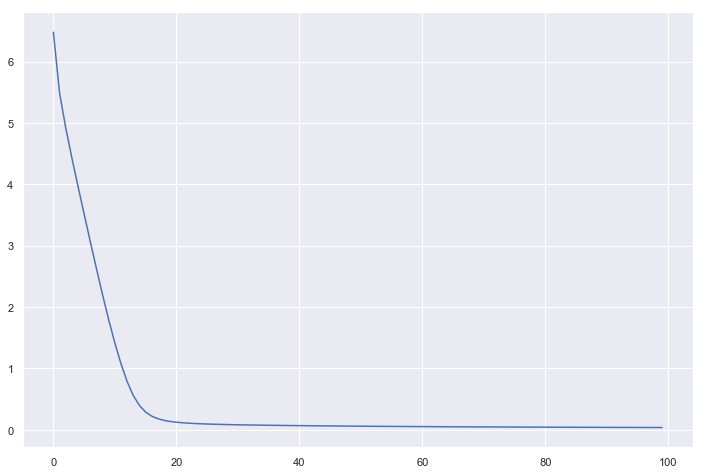

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(losses)
plt.show()

# Apply and Evaluate the CBOW Model 

In [49]:
from lazyme import color_str

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem is essentially this
essentially 	 problem is to this :
this 		 is essentially ______ : if
: 		 essentially this association if a
if 		 this : is a word
a 		 : if a word (
word 		 if a simple ( or
( 		 a word ( or bigram
or 		 word ( social bigram ,
bigram 		 ( or ) , or
<unk> 		 , or uncorrelated , or
<unk> 		 , or defined etc .
is 		 the web of a vast
a 		 web is sample vast re-
vast 		 is a the re- source
re- 		 a vast accurate source for
source 		 vast re- ’ for many
the 		 is that the association is
association 	 that the probability is random
is 		 the association of random ,
random 		 association is also , arbitrary
, 		 is random distribution arbitrary ,
arbitrary 	 random , arbitrary , motivated
, 		 , arbitrary and motivated or
motivated 	 arbitrary , motivated or pre-
<unk> 		 or pre- f ( r
, 		 ( r ) a ,
<unk> 		 a , 1977 , p
their 		 however , rens methods are
example 	 , for example , from
, 		 for example associated from just
from 		 example , to just th

of 		 1 % the them ,
them 		 % of ) , devastate
<unk> 		 , devastate just one of
the 		 one of the verbs for
verbs 		 of the filter for which
for 		 the verbs ______ which we
which 		 verbs for these we have
<unk> 		 we have each of data
<unk> 		 , and a thresholding methods
will 		 thresholding methods where distinguish associated
distinguish 	 methods will ______ associated scfs
associated 	 will distinguish probabilities scfs from
scfs 		 distinguish associated two from noise
from 		 associated scfs … noise .


In [50]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.2723404255319149


# Go back to the 90th Epoch

In [51]:
model_90 = CBOW(vocab_size, embd_size, window_size, hidden_size)
model_90 = torch.nn.DataParallel(model_90)
model_90.load_state_dict(torch.load('cbow_checkpoint_90.pt'))
model_90.eval()

DataParallel(
  (module): CBOW(
    (embeddings): Embedding(1303, 100)
    (linear1): Linear(in_features=400, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=1303, bias=True)
  )
)

In [54]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model_90(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem is essentially this
essentially 	 problem is to this :
this 		 is essentially ______ : if
: 		 essentially this association if a
if 		 this : is a word
a 		 : if a word (
word 		 if a simple ( or
( 		 a word ( or bigram
or 		 word ( social bigram ,
bigram 		 ( or ) , or
<unk> 		 , or uncorrelated , or
<unk> 		 , or defined etc .
is 		 the web of a vast
a 		 web is sample vast re-
vast 		 is a the re- source
re- 		 a vast accurate source for
source 		 vast re- ’ for many
the 		 is that the association is
association 	 that the probability is random
is 		 the association of random ,
random 		 association is also , arbitrary
, 		 is random distribution arbitrary ,
arbitrary 	 random , arbitrary , motivated
, 		 , arbitrary and motivated or
motivated 	 arbitrary , motivated or pre-
<unk> 		 or pre- f ( r
, 		 ( r ) a ,
<unk> 		 a , 1977 , p
their 		 however , rens methods are
example 	 , for example , from
, 		 for example associated from just
from 		 example , to just th

than 		 systematically greater than 0.5 ?
1 		 with just the % of
% 		 just 1 % of them
of 		 1 % the them ,
them 		 % of ) , devastate
<unk> 		 , devastate just one of
the 		 one of the verbs for
verbs 		 of the filter for which
for 		 the verbs ______ which we
which 		 verbs for these we have
<unk> 		 we have each of data
<unk> 		 , and a thresholding methods
will 		 thresholding methods where distinguish associated
distinguish 	 methods will ______ associated scfs
associated 	 will distinguish probabilities scfs from
scfs 		 distinguish associated two from noise
from 		 associated scfs … noise .


In [55]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.2723404255319149


# Go back to the 10th Epoch

In [56]:
model_10 = CBOW(vocab_size, embd_size, window_size, hidden_size)
model_10 = torch.nn.DataParallel(model_10)
model_10.load_state_dict(torch.load('cbow_checkpoint_10.pt'))
model_10.eval()

DataParallel(
  (module): CBOW(
    (embeddings): Embedding(1303, 100)
    (linear1): Linear(in_features=400, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=1303, bias=True)
  )
)

In [57]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model_10(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem is essentially this
essentially 	 problem is to this :
this 		 is essentially ______ : if
: 		 essentially this used if a
if 		 this : for a word
a 		 : if a word (
word 		 if a simple ( or
( 		 a word ( or bigram
or 		 word ( at bigram ,
bigram 		 ( or ) , or
<unk> 		 , or random , or
<unk> 		 , or ______ etc .
is 		 the web of a vast
a 		 web is very vast re-
vast 		 is a the re- source
re- 		 a vast accurate source for
source 		 vast re- ______ for many
the 		 is that the association is
association 	 that the probability is random
is 		 the association of random ,
random 		 association is also , arbitrary
, 		 is random and arbitrary ,
arbitrary 	 random , and , motivated
, 		 , arbitrary and motivated or
motivated 	 arbitrary , motivated or pre-
<unk> 		 or pre- language ( r
, 		 ( r ) a ,
<unk> 		 a , random , p
their 		 however , and methods are
example 	 , for example , from
, 		 for example : from just
from 		 example , to just those
<unk> 		 just those ______

<unk> 		 , be random as :
are 		 as : for the error
the 		 : are very error terms
error 		 are the ( terms systematically
terms 		 the error ______ systematically greater
systematically 	 error terms or greater than
greater 	 terms systematically greater than 0.5
than 		 systematically greater than 0.5 ?
1 		 with just the % of
% 		 just 1 % of them
of 		 1 % the them ,
them 		 % of ) , devastate
<unk> 		 , devastate random one of
the 		 one of the verbs for
verbs 		 of the filter for which
for 		 the verbs ______ which we
which 		 verbs for these we have
<unk> 		 we have each of data
<unk> 		 , and a thresholding methods
will 		 thresholding methods where distinguish associated
distinguish 	 methods will ______ associated scfs
associated 	 will distinguish probabilities scfs from
scfs 		 distinguish associated two from noise
from 		 associated scfs … noise .


In [58]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.2553191489361702


# How to Handle Unknown Words? 

This is not the best way to handle unknown words, but we can simply assign an index for unknown words.

In [67]:
vocab = Dictionary(['this is a foo bar sentence'.split()])
dict(vocab.items())

{0: 'a', 1: 'bar', 2: 'foo', 3: 'is', 4: 'sentence', 5: 'this'}

In [68]:
# See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.patch_with_special_tokens
vocab = Dictionary(['this is a foo bar sentence'.split()])
special_tokens = {'<pad>': 0, '<unk>': 1}
vocab.patch_with_special_tokens(special_tokens)
dict(vocab.items())

AttributeError: 'Dictionary' object has no attribute 'patch_with_special_tokens'

# Lets Rewrite the `Word2VecText` Object

Now with the (i) unknown word patch in the vocabulary as well as (ii) `skipgram_iterator`

In [ ]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Add the unknown word patch here.
        self.vocab = Dictionary(self.sents)
        special_tokens = {'<pad>': 0, '<unk>': 1}
        self.vocab.???(special_tokens)
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.???(tokens, unknown_word_index=1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                ???

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = torch.mm(embed_focus, torch.t(embed_context))
        log_probs = F.logsigmoid(score)
        return log_probs

In [ ]:
embd_size = 100
learning_rate = 0.03
hidden_size = 300
window_size = 3

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='skipgram')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.MSELoss() # binary classification.
model = SkipGram(vocab_size, embd_size,)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epcoh_loss = 0
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x1, x2 = w2v_io['x']
            x1, x2 = tensor(x1), tensor(x2)
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.float))
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x1, x2)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epcoh_loss += float(loss)
    torch.save(model.state_dict(), 'skipgram_checkpoint_{}.pt'.format(_e))
    losses.append(epcoh_loss)



In [ ]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        _, prediction =  torch.max(model(x1, x2), 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [ ]:
print('Accuracy:', true_positive/all_data)

## Download the Collobert and Weston SENNA Embeddings

In [ ]:
!pip install kaggle
!mkdir -p .kaggle
!echo '{"username":"natgillin","key":"54ae95ab760b52c3307ed4645c6c9b5d"}' > .kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json
!kaggle datasets download -d alvations/vegetables-senna-embeddings --force -p ./


## Lets Rewrite the Word2VecText object with the pretrained embeddings. 


In [ ]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Loads the pretrained keys. 
        with open('senna.wiki-reuters.lm2.50d.txt') as fin:
            pretrained_keys = {line.strip():i for i, line in enumerate(fin)}
        self.vocab = Dictionary({})
        self.vocab.token2id = pretrained_keys
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=-1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

## Test Pretrained Embeddings on the Skipgram Task

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, pretrained_npy):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding.???(pretrained_npy)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = ???
        log_probs = F.logsigmoid(score)
        return log_probs

In [ ]:
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='skipgram')
pretrained_npy = torch.tensor(np.load('senna.wiki-reuters.lm2.50d.npy'))
pretrained_model = SkipGram(pretrained_npy)

In [ ]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        pretrained_model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        if -1 in (x1, x2): # Skip unknown words.
            continue
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        with torch.no_grad():
            logprobs = pretrained_model(x1, x2)
            _, prediction =  torch.max(logprobs, 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [ ]:
with open('senna.wiki-reuters.lm2.50d.txt') as fin:
    pretrained_keys = {line.strip():i for i, line in enumerate(fin)}

In [ ]:
print('Accuracy:', true_positive/all_data)

## Test Pretrained Embeddings on the CBOW Task

In [ ]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        # See https://pytorch.org/docs/stable/nn.html?highlight=from_pretrained#torch.nn.Embedding.from_pretrained
        self.embeddings = nn.Embedding.???(pretrained_npy)
        self.linear1 = nn.Linear(???, hidden_size)
        self.linear2 = nn.Linear(hidden_size, ???)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [ ]:
window_size = 2 
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

In [ ]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
        with torch.no_grad():
            _, prediction =  torch.max(pretrained_cbow_model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

In [ ]:
print('Accuracy:', true_positive/all_data)

## Unfreeze the Embedddings and Tune it on the CBOW Task

In [ ]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        # https://pytorch.org/docs/stable/nn.html?highlight=from_pretrained#torch.nn.Embedding.from_pretrained
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy, ???=False)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [ ]:
window_size = 2 
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

In [ ]:
learning_rate = 0.003
criterion = nn.NLLLoss()
optimizer = optim.SGD(pretrained_cbow_model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(pretrained_cbow_model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x = tensor(w2v_io['x'])
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.long))
            
            if -1 in x or int(y) == -1:
                continue
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = pretrained_cbow_model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_finetuning_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))

